# Data Exploration
<p>
    This notebook should contain preliminary data exploration and graphing of the data set.
</p>
<p>
    Last modified 4/14/18 by Kate Baumli
</p>

In [153]:
! pip install gender-guesser
import pandas as pd
import numpy as np
import re
import nltk
import math
import operator
import seaborn as sns
import matplotlib.pyplot as plt
import gender_guesser.detector as gender
from collections import Counter
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/katebaumli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

First load up the data.

In [56]:
filepath = '../data/kaggle-data/'
filename = 'merged_data.csv'
data = pd.read_csv(filepath + filename)
# drop extra index column
data.drop('Unnamed: 0', axis=1, inplace=True)

In [57]:
# Output suppressed
#data.describe()
#data.info()
data.head()

,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url.1,views
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morning\nhow are you\nlaughter\nits been ...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chris\nand its truly a grea...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,if youre here today — and im very happy that y...,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869


In [58]:
# Output suppressed, this is to check data was cleaned properly
#print(data.clean_transcripts[0]) 

In [59]:
print('The number of NaN clean transcripts is:\t\t{}'.
      format(data.clean_transcripts.isnull().sum()))
print('The number of NaN original transcripts is:\t{}'.
      format(data.transcript.isnull().sum()))

The number of NaN clean transcripts is:		83
The number of NaN original transcripts is:	83


That is something we need to look into... For the moment I am going to drop them.

In [60]:
# Assuming the NaN are the same rows in both columns
data_trimmed = data.dropna(subset=['clean_transcripts'])

Let's look at how our features are correlated:

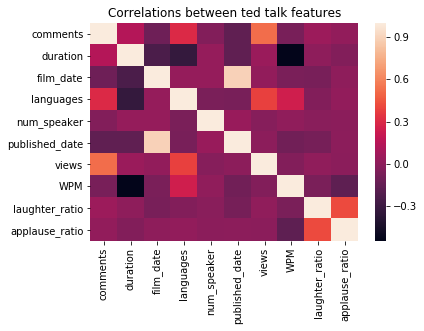

In [134]:
correlations = data_trimmed.corr()
_ = sns.heatmap(correlations)
_ = plt.title('Correlations between ted talk features')
plt.show()

Nothing too shocking here. We see that publish date and film date are correlated, as would be expected. We also see that views and comments are correlated, again, no shock there.

In [12]:
# Find transcript with the most words
maxLen = 0
for row in data_trimmed.itertuples():
    if len(row.clean_transcripts.split()) >= maxLen:
        maxLen = len(row.clean_transcripts.split()) 
        longestTalk = row.name
print(maxLen)
print(longestTalk)

9176
Zeynep Tufekci: Machine intelligence makes human morals more important


In [86]:
def getWords(df,removeStopWords):
    words = []
    for row in df.itertuples():
        words.extend(row.clean_transcripts.split())
    
    # Removing Stopwords ('the', 'it', 'is', 'and', etc)
    if removeStopWords:
        stopWords = set(stopwords.words('english'))
        print("Removing the stop words... ")
        
        filteredWords =[]
        for word in words: 
            if word not in stopWords:
                filteredWords.append(word)
                
        return filteredWords
    
    return words

In [87]:
def mostFrequentWords(df, numWordsDesired, descriptor='', removeStopWords=True, normalize=False):
    # This loops over all rows in the clean transcripts column and 
    # puts every word in every transcript into a list called words
    words = getWords(df,removeStopWords)
    
    descriptor2=''
    if removeStopWords:
        descriptor2 = '(excluding stop words like \'the\')'
    
    # Get counts for each word
    wordCounts = Counter(words)
    print(descriptor,'Number of unique words:',descriptor2,len(wordCounts))

    # Grab the most common words
    mostCommon = dict()
    for word, wordCount in wordCounts.most_common(numWordsDesired):
        if normalize:
            # Divide by total # of words to get percentage of words said
            mostCommon[word] = wordCount/float(len(words)) 
        else:
            mostCommon[word] = wordCount
    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(mostCommon.keys()), list(mostCommon.values()))
    title = ('The '+str(numWordsDesired)+' Most Common Words ' + descriptor2 +
             ' In All ' + descriptor +' TED Talk Transcripts')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    
    # Return list of most common words
    return mostCommon

Removing the stop words... 
 Number of unique words: (excluding stop words like 'the') 102906


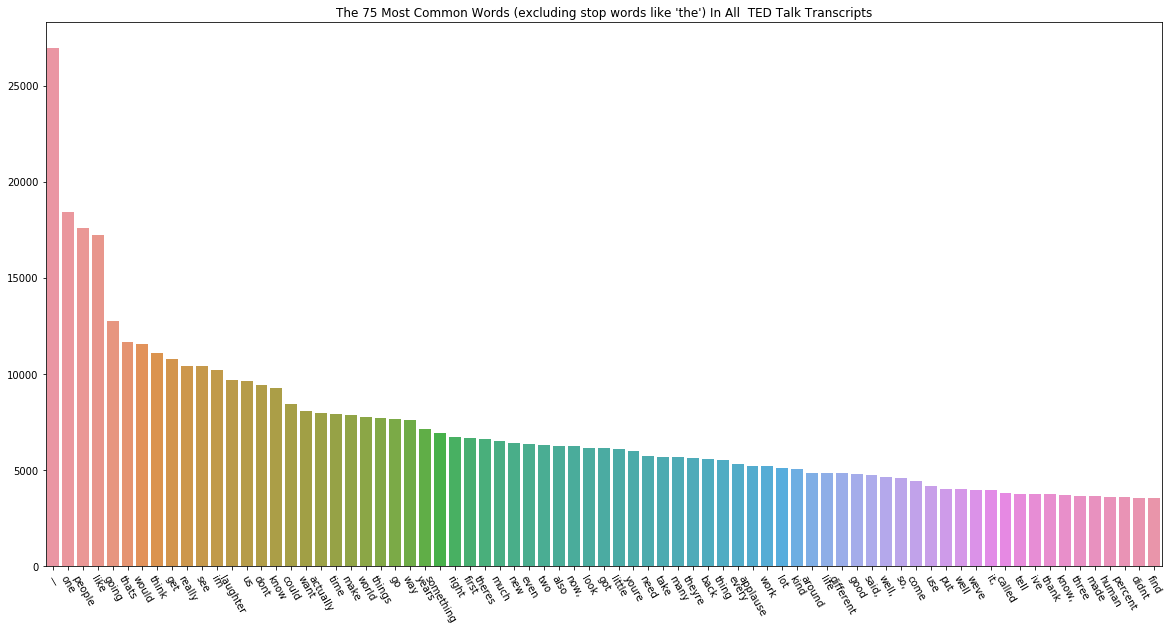

In [135]:
_ = mostFrequentWords(data_trimmed,75)

### Let's break the data set into two segments based on (guessed) speaker gender

In [136]:
genDetector = gender.Detector()
speakerNames = data_trimmed.main_speaker.tolist()

speakerFirstNames = []
genders = []
for name in speakerNames:
    firstLastName = name.split(' ')
    firstName = firstLastName[0]
    speakerFirstNames.append(firstName)
    genders.append(genDetector.get_gender(firstName))
data_trimmed['gender'] = genders

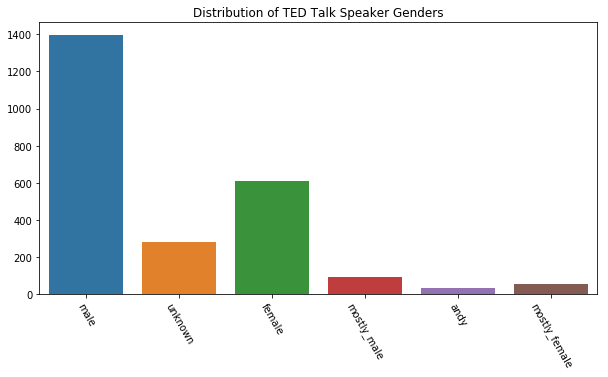

In [137]:
# Plot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

I'm going to go ahead and add the "mostly_female" names to female category and "mostly_male" names to male category. Unsure what to do about androgynous/unknown categories. We might have to go through and manually label these.<p>
Also, since classes are skewed we should normalize features when comparing.

In [138]:
for i,gender in enumerate(genders):
    if gender == 'mostly_male':
        genders[i] = 'male'
    if gender == 'mostly_female':
        genders[i] = 'female'
    if gender == 'andy':
        genders[i] = 'unknown' # No need to have 2 unknown categories if we're going to have to manually label anyways

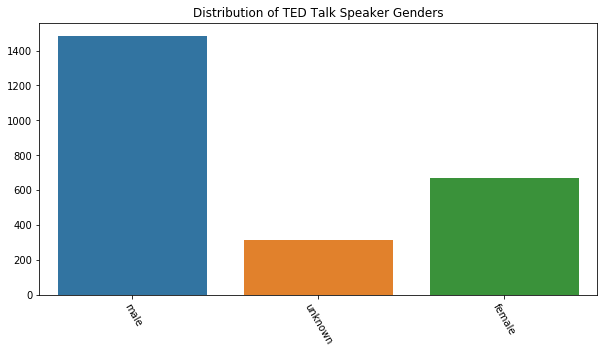

In [139]:
data_trimmed['gender'] = genders
# Replot a histogram of genders
genderCounts = Counter(genders)
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(list(genderCounts.keys()), list(genderCounts.values()))
title = 'Distribution of TED Talk Speaker Genders'
_ = plt.title(title)
_ = plt.xticks(rotation=300)
plt.show()

Right off the bat we can see that about twice as many speakers are men than women(disregarding the unknown). Let's compare the average # of views of men vs women.<BR><br>Let's see if any of the features seem highly correlated with gender:

In [140]:
menTED = data_trimmed[data_trimmed['gender'] == 'male']
womenTED = data_trimmed[data_trimmed['gender'] == 'female']
print('Description of male speaker TED data:')
menTED.describe()
print('Description of female speaker TED data:')
womenTED.describe()

Description of male speaker TED data:


,comments,duration,film_date,languages,num_speaker,published_date,views,WPM,laughter_ratio,applause_ratio
count,1486.000000,1486.000000,1.486000e+03,1486.000000,1486.000000,1.486000e+03,1.486000e+03,1486.000000,1486.000000,1486.000000
mean,205.774563,861.121803,1.300717e+09,27.831763,1.024226,1.326164e+09,1.723914e+06,171.722377,0.002013,0.001315
std,306.860395,401.517030,1.231169e+08,9.083598,0.166420,8.987197e+07,2.499383e+06,141.606823,0.003264,0.002244
min,9.000000,135.000000,7.464960e+07,0.000000,1.000000,1.151367e+09,6.666800e+04,0.118110,0.000000,0.000000
25%,70.000000,601.250000,1.248134e+09,23.000000,1.000000,1.254403e+09,7.429048e+05,90.996565,0.000000,0.000424
50%,128.000000,894.500000,1.316822e+09,28.000000,1.000000,1.327637e+09,1.139746e+06,140.201328,0.001081,0.000808
75%,238.000000,1074.000000,1.383091e+09,33.000000,1.000000,1.397121e+09,1.771561e+06,196.999294,0.002471,0.001512
max,6404.000000,5256.000000,1.493078e+09,72.000000,3.000000,1.496418e+09,4.722711e+07,1273.621622,0.055556,0.055556


Description of female speaker TED data:


,comments,duration,film_date,languages,num_speaker,published_date,views,WPM,laughter_ratio,applause_ratio
count,666.000000,666.000000,6.660000e+02,666.000000,666.000000,6.660000e+02,6.660000e+02,666.000000,666.000000,666.000000
mean,188.833333,792.277778,1.342679e+09,28.342342,1.031532,1.358917e+09,1.745882e+06,174.490312,0.002016,0.001342
std,251.704674,315.409746,1.047912e+08,8.277694,0.252321,9.052727e+07,2.689112e+06,136.874152,0.003606,0.001504
min,6.000000,140.000000,8.863776e+08,0.000000,1.000000,1.152490e+09,1.211860e+05,0.051858,0.000000,0.000000
25%,64.000000,577.250000,1.280167e+09,24.000000,1.000000,1.291940e+09,8.127375e+05,98.282246,0.000000,0.000500
50%,120.000000,794.000000,1.354795e+09,28.000000,1.000000,1.362329e+09,1.131452e+06,144.285872,0.001072,0.000844
75%,207.750000,1010.250000,1.432274e+09,33.000000,1.000000,1.441098e+09,1.616600e+06,197.706592,0.002522,0.001577
max,2877.000000,2853.000000,1.492992e+09,57.000000,4.000000,1.496401e+09,4.315540e+07,1327.285714,0.061856,0.016393


Let's compare the frequency of words:

Removing the stop words... 
Male Speaker Number of unique words: (excluding stop words like 'the') 80609


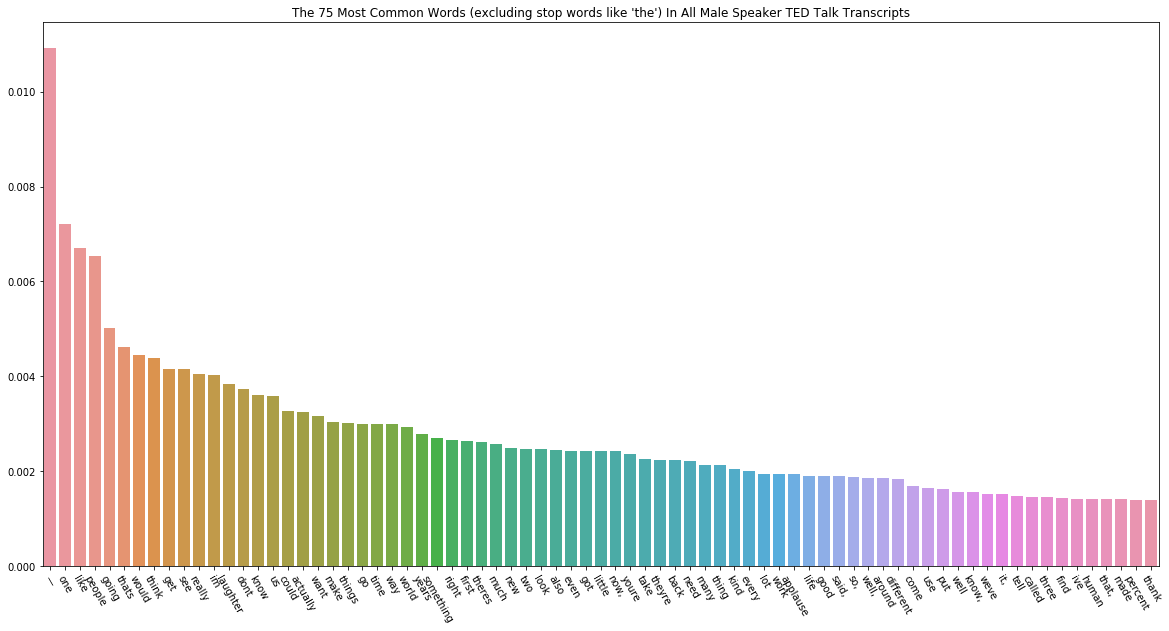

Removing the stop words... 
Female Speaker Number of unique words: (excluding stop words like 'the') 50752


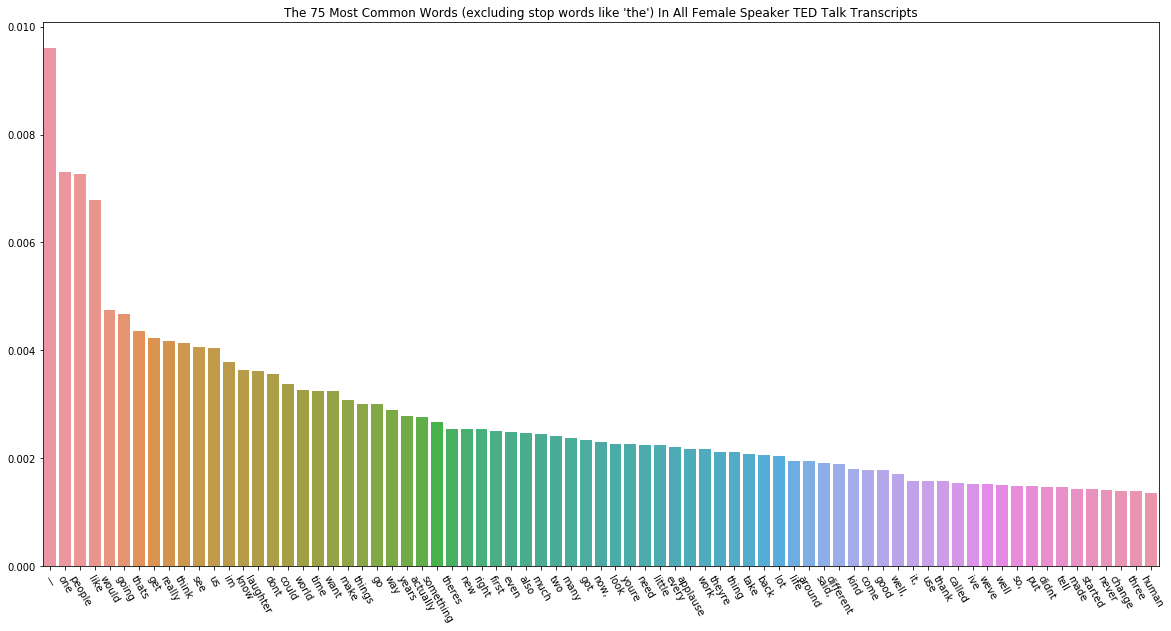

In [141]:
maleCommonWords = mostFrequentWords(menTED,75,'Male Speaker',normalize=True)
femaleCommonWords = mostFrequentWords(womenTED,75,'Female Speaker',normalize=True)

In [22]:
onlyMaleCommonWords = [word for word in maleCommonWords.keys() if word not in femaleCommonWords]
print(onlyMaleCommonWords) 
onlyFemaleCommonWords = [word for word in femaleCommonWords.keys() if word not in maleCommonWords]
print(onlyFemaleCommonWords)

['know,', 'find', 'that,', 'percent']
['didnt', 'started', 'never', 'change']


### Previous research on the differences of speech patterns between men and women, we have found that women are more likely to use speech qualifiers/intensifiers such as 'very','so','such','extremely','really','totally','absolutely', or 'too'. Let's look into that a little more here and compare our talks:

In [145]:
def getNormalizedGenderWordCounts():
    maleWords = getWords(menTED,removeStopWords=False)
    femaleWords = getWords(womenTED,removeStopWords=False)

    # Get counts for each word
    maleWordCounts = Counter(maleWords)
    femaleWordCounts = Counter(femaleWords)

    # Normalize counts by number of total words spoken by men 
    normalizedMaleWordCounts = {}
    for word,count in dict(maleWordCounts).items():
        normalizedMaleWordCounts[word] = count/float(len(maleWords))

    # Normalize counts by number of total words spoken by women 
    normalizedFemaleWordCounts = {}
    for word,count in dict(femaleWordCounts).items():
        normalizedFemaleWordCounts[word] = count/float(len(femaleWords))
        
    return normalizedMaleWordCounts, normalizedFemaleWordCounts

In [146]:
def menVsWomenWordCounts(wordsToCount):    
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    maleCount = 0
    for word,count in normalizedMaleWordCounts.items():
        if word in wordsToCount:
            maleCount += count
        
    femaleCount = 0
    for word,count in normalizedFemaleWordCounts.items():
        if word in wordsToCount:
            femaleCount += count
            
    return maleCount, femaleCount

In [102]:
intensifiers = ['very','so','such','really','totally','too']
maleIntensifierCount, femaleIntensifierCount = menVsWomenWordCounts(intensifiers)

print('Percentage of intensifier words for men:  ',maleIntensifierCount)
print('Percentage of intensifier words for women:',femaleIntensifierCount)

Percentage of intensifier words for men:   0.012886569068201684
Percentage of intensifier words for women: 0.01288625031949227


In [106]:
uncertainty = ['um','uh','-']
maleUncertaintyCount, femaleUncertaintyCount = menVsWomenWordCounts(uncertainty)
print('Percentage of uncertainty words for men:  ',maleUncertaintyCount)
print('Percentage of uncertainty words for women:',femaleUncertaintyCount)

Percentage of uncertainty words for men:   1.8242504330994558e-05
Percentage of uncertainty words for women: 1.1177572127010008e-05


Flagging um and uh might prove useful in differentiating between genders

In [20]:
warmAndAgreeable = ['family','friends','wonderful','blessed','amazing','loving','husband','thankful']
maleWarmAgreeableCount, femaleWarmAgreeableCount = menVsWomenWordCounts(warmAndAgreeable)

print('Percentage of warm and agreeable words for men:  ',maleWarmAgreeableCount)
print('Percentage of warm and agreeable words for women:',femaleWarmAgreeableCount)

Total number of words:  3124571
Total number of words:  1336634
Percentage of warm and agreeable words for men:   0.0008449159900671165
Percentage of warm and agreeable words for women: 0.00105937751097159


In [21]:
coldHearted = ['kill','kills','dead','killing','die','swear','dead','murder']
maleColdHeartedCount, femaleColdHeartedCount = menVsWomenWordCounts(coldHearted)

print('Percentage of cold hearted words for men:  ',maleColdHeartedCount)
print('Percentage of cold hearted words for women:',femaleColdHeartedCount)

Total number of words:  3124571
Total number of words:  1336634
Percentage of cold hearted words for men:   0.00034372718686821323
Percentage of cold hearted words for women: 0.0004114813778491345


Our data does not reflect the findings in these studies about intensifier words.
In fact, our male TED speakers actually tend to use these words more frequently than do the women. Some other studies https://www.washingtonpost.com/news/the-intersect/wp/2016/05/28/these-are-the-words-most-associated-with-men-and-women-according-to-facebook-status-updates/?noredirect=on&utm_term=.54981ab1318a have shown that women tend to use words that are more "warm and agreeable"

In [22]:
rational = ['opinion','opinions','logic','logical','based','political','fact','moral','beliefs']
maleRationalCount, femaleRationalCount = menVsWomenWordCounts(rational)
print('Percentage of rational words for men:  ',maleRationalCount)
print('Percentage of rational words for women:',femaleRationalCount)

Total number of words:  3124571
Total number of words:  1336634
Percentage of rational words for men:   0.0007620246107385623
Percentage of rational words for women: 0.0007773257301550014


Let's compare speed of speech of men and women. 

In [23]:
menTED.head()

,Unnamed: 0.1,transcript,url,clean_transcripts,comments,description,duration,event,film_date,languages,...,published_date,ratings,related_talks,speaker_occupation,tags,title,url.1,views,stripped_transcripts,gender
0,0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,good morning\nhow are you\nlaughter\nits been ...,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,"['good', 'morning', 'how', 'are', 'you', 'laug...",male
1,1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,"thank you so much, chris\nand its truly a grea...",265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"['thank', 'you', 'so', 'much,', 'chris', 'and'...",male
2,2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,"music: the sound of silence, simon & garfunkel...",124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,...,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"['music:', 'the', 'sound', 'of', 'silence,', '...",male
4,4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,"about 10 years ago, i took on the task to teac...",593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,...,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"['about', '10', 'years', 'ago,', 'i', 'took', ...",male
5,5,Thank you. I have to tell you I'm both challen...,https://www.ted.com/talks/tony_robbins_asks_wh...,thank you\ni have to tell you im both challeng...,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,...,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401,"['thank', 'you', 'i', 'have', 'to', 'tell', 'y...",male


In [69]:
WPM = []
for row in data_trimmed.itertuples():
    minutes = row.duration/float(60) # Duration is in seconds
    numWords = len(row.clean_transcripts.split(' '))
    WPM.append(numWords/float(minutes))
data_trimmed['WPM'] = WPM

/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [142]:
def compareGenders(feature):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
    # violin plots in seaborn require 2 catagorical variables ('x' and 'hue'). We use 'gender' for hue.
    placeholder = np.zeros(len(data_trimmed[feature].values))
    _ = sns.violinplot(x=placeholder, y=data_trimmed[feature], hue=data_trimmed.gender, ax=axes[0], palette='bright')
    _ = axes[0].set_title('Comparing Distribution of '+feature+ ' by Gender')
    _ = sns.boxplot(x=placeholder,y=data_trimmed[feature],hue=data_trimmed.gender, ax = axes[1])
    _ = axes[1].set_title('Comparing Distribution of '+feature+ ' by Gender')
    plt.show()

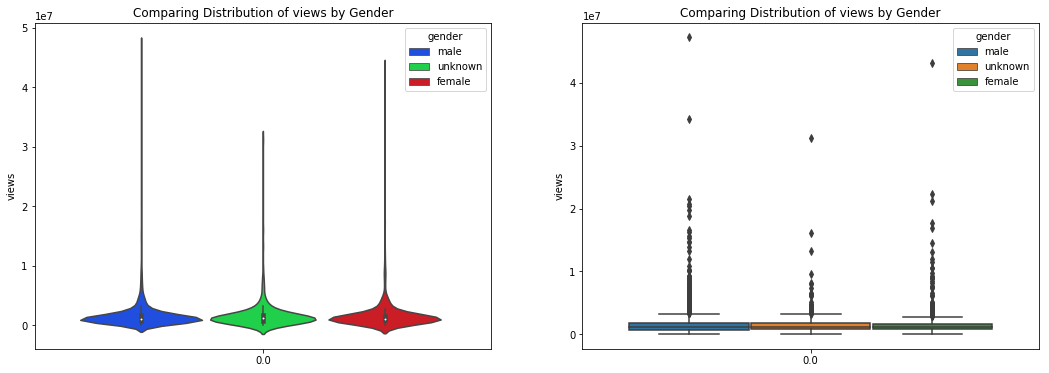

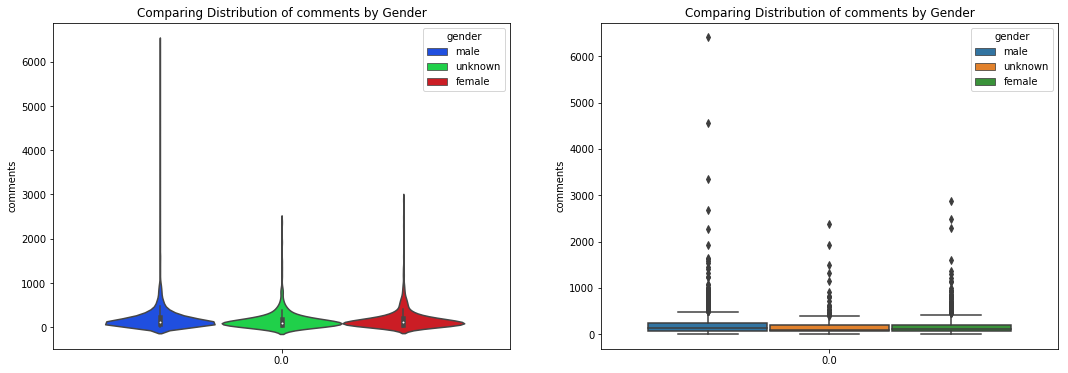

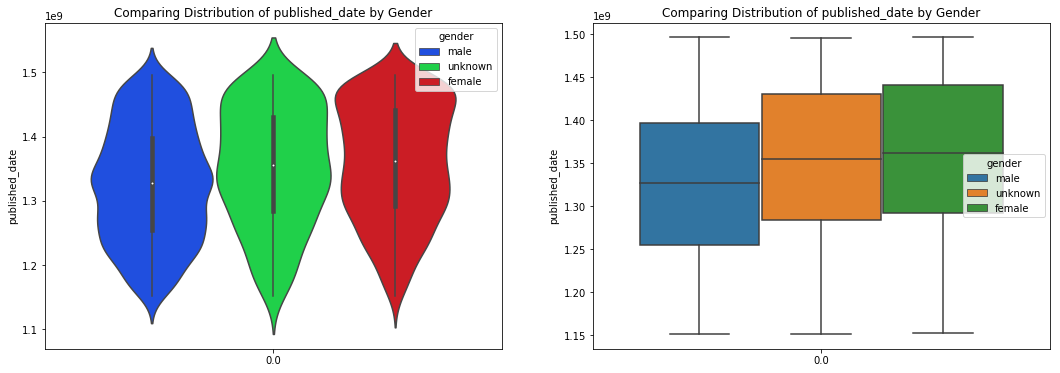

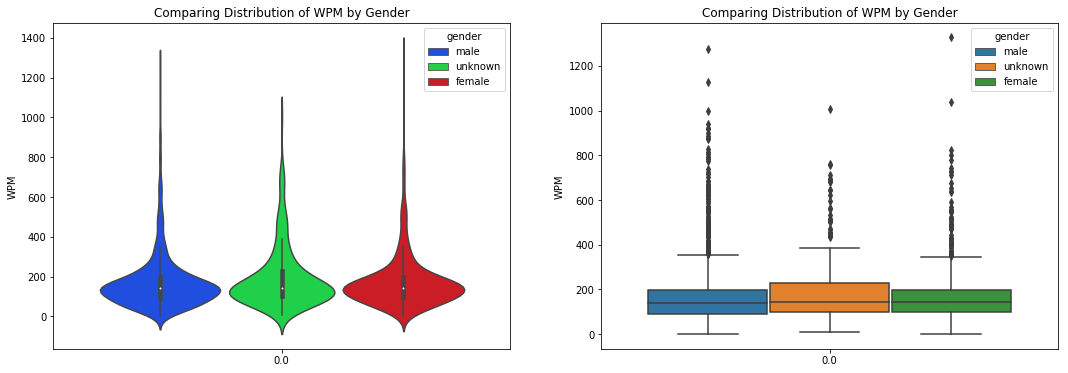

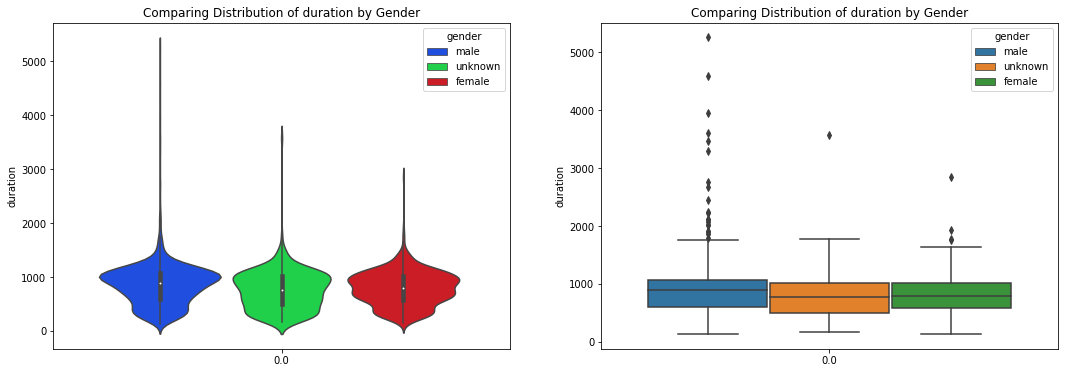

In [143]:
compareGenders('views')
compareGenders('comments')
compareGenders('published_date')
compareGenders('WPM')
compareGenders('duration')

Duration and published date seem to correlate with gender based on the plots above. These features could be useful to highlight when building a gender classifier. 

Now let's compare the amount of (laughter) and (applause) recieved by men and women normalized by the length of the talk.

In [119]:
laughter = []
applause = []
for row in data_trimmed.itertuples():
    words = row.clean_transcripts.split() # Not the cleaned transcripts because those take out the () around laughter and applause
    laughCount = 0
    applauseCount = 0
    for word in words:
        if word == 'laughter':
            laughCount += 1
        if word == 'applause':
            applauseCount += 1
    laughter.append(laughCount/float(len(words))) # laugh to words ratio
    applause.append(applauseCount/float(len(words))) # applause to words ratio

data_trimmed['laughter_ratio'] = laughter
data_trimmed['applause_ratio'] = applause

/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/katebaumli/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


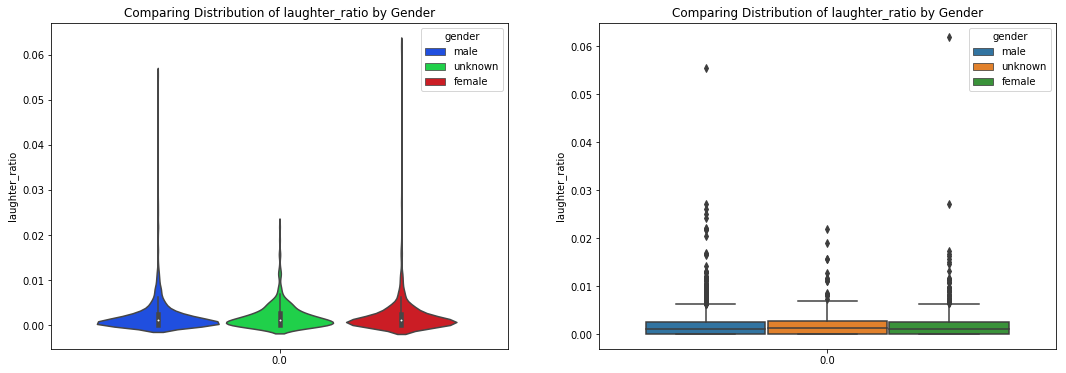

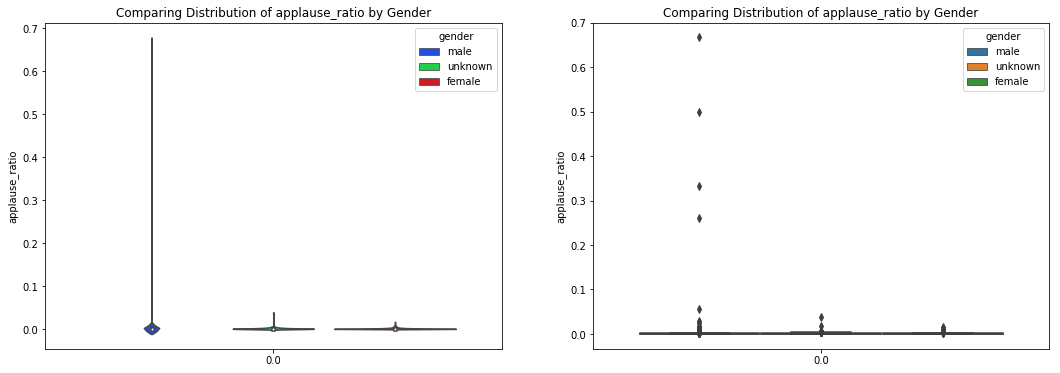

In [122]:
compareGenders('laughter_ratio')
compareGenders('applause_ratio')

There seems to be some crazy outliers in applause ratio for men. Unsure of what to make of this. Actually, they might be performers or something where they play music and therefore don't speak many words. Let's see:

In [129]:
for row in data_trimmed.itertuples():
    if row.applause_ratio > 0.2:
        print(row.transcript)

(Applause)(Music)(Applause)
(Music)(Applause)(Music)(Music) (Applause)(Music) (Applause) (Applause)Herbie Hancock: Thank you. Marcus Miller. (Applause) Harvey Mason. (Applause)Thank you. Thank you very much. (Applause)
(Mechanical noises)(Music) (Applause)
(Music)(Music) (Applause)(Applause)


It appears that these talks don't actually have a transcript to go along with them. Let's drop these from the data set. (I went back and regenerated all the other plots/analysis with these talks dropped, to get a more clear analysis)

In [132]:
data_trimmed = data_trimmed[data_trimmed.applause_ratio < 0.2]

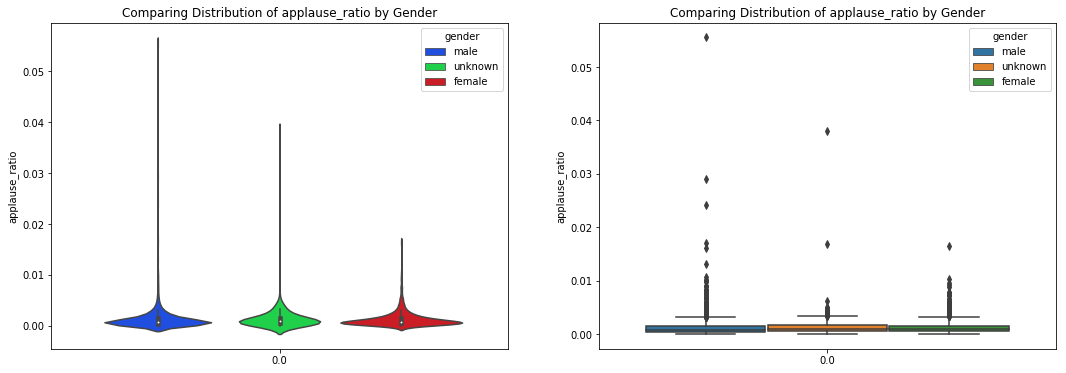

In [144]:
compareGenders('applause_ratio')

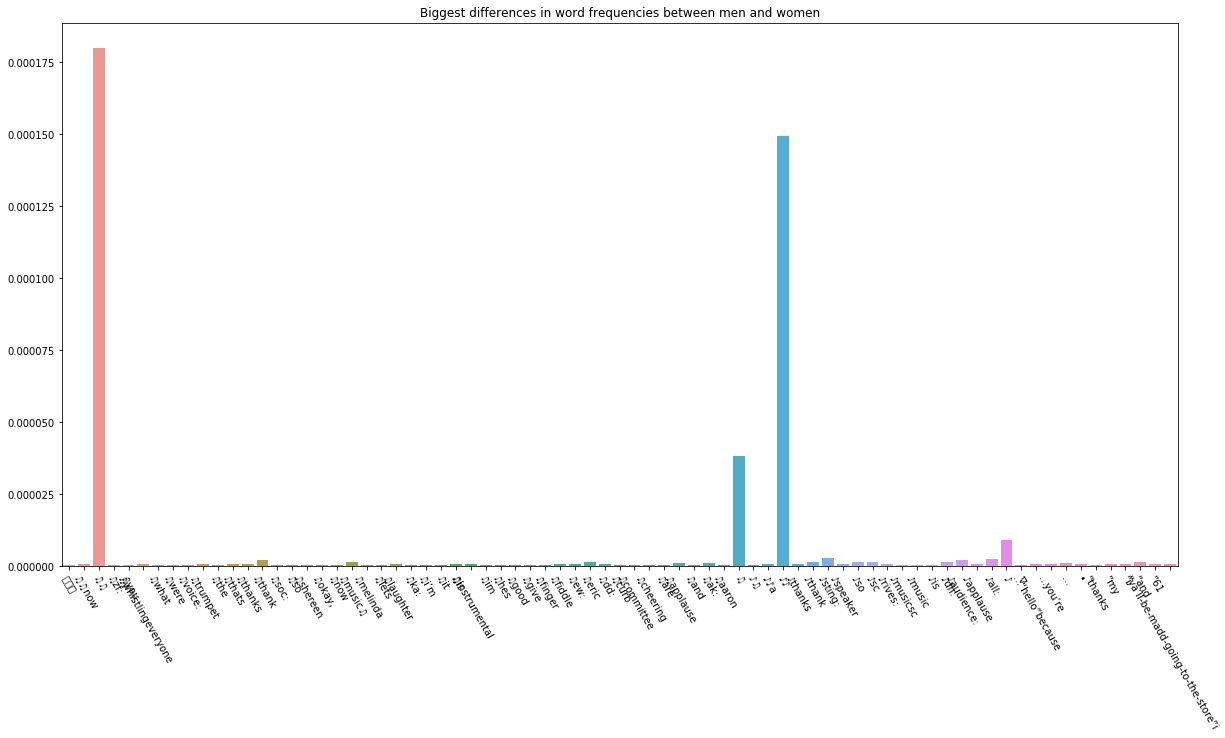

[('送你葱', 3.200471109347296e-07),
 ('♫♫now', 7.451714751340005e-07),
 ('♫♫', 0.00017966853395659055),
 ('♫zf:', 3.200471109347296e-07),
 ('♫you', 3.200471109347296e-07),
 ('♫whistlingeveryone', 7.451714751340005e-07),
 ('♫what', 3.200471109347296e-07),
 ('♫were', 3.200471109347296e-07),
 ('♫voice:', 3.200471109347296e-07),
 ('♫trumpet', 6.400942218694592e-07),
 ('♫the', 3.200471109347296e-07),
 ('♫thats', 6.400942218694592e-07),
 ('♫thanks', 7.451714751340005e-07),
 ('♫thank', 2.135252523278566e-06),
 ('♫soc:', 3.200471109347296e-07),
 ('♫so', 3.200471109347296e-07),
 ('♫shereen', 3.200471109347296e-07),
 ('♫okay,', 3.200471109347296e-07),
 ('♫now', 3.200471109347296e-07),
 ('♫music♫', 1.2801884437389185e-06),
 ('♫melinda', 3.200471109347296e-07),
 ('♫lets', 3.200471109347296e-07),
 ('♫laughter', 7.451714751340005e-07),
 ('♫ka:', 3.200471109347296e-07),
 ('♫i’m', 3.200471109347296e-07),
 ('♫it', 3.200471109347296e-07),
 ('♫is', 7.451714751340005e-07),
 ('♫instrumental', 7.45171475134000

In [162]:
def sortWordsByGenderGap():
    normalizedMaleWordCounts, normalizedFemaleWordCounts = getNormalizedGenderWordCounts()
    doneWords = set() # To keep track of the words we've done
    genderGap = dict() # To record differnce by gender of word frequency
    
    # Loop through all male words and get gender difference
    for word, maleCount in normalizedMaleWordCounts.items():
        doneWords.add(word)
        if word in normalizedFemaleWordCounts.keys():
            femaleCount = normalizedFemaleWordCounts[word]
        else:
            femaleCount = 0
        diff = math.fabs(maleCount-femaleCount)
        genderGap[word] = diff
        
    for word, femaleCount in normalizedFemaleWordCounts.items():
        # We already went through every word in male dictionary, if we reach it here, word count for men is 0,
        # therefore the difference between men and women frequencies for this word is just the women frequency.
        if word not in doneWords:
            genderGap[word] = femaleCount 
    sortedGenderGap = sorted(genderGap.items(), key=operator.itemgetter(0),reverse=True)
    
    # Plot a histogram
    _ = plt.figure(figsize=(20,10))
    _ = sns.barplot(list(dict(sortedGenderGap[0:75]).keys()), list(dict(sortedGenderGap[0:75]).values()))
    title = ('Biggest differences in word frequencies between men and women')
    _ = plt.title(title)
    _ = plt.xticks(rotation=300)
    plt.show()
    return sortedGenderGap
sortWordsByGenderGap()

Looks like we still have some data cleaning to do... we should eliminate all symbols that are not letters. There are apparently music suymbols, dashes, semi colons, and commas in the "clean" trancripts

In [152]:
data_trimmed['gender'].value_counts()

male       1486
female      666
unknown     311
Name: gender, dtype: int64

12.68% of our data is categorized as unknown.

In [41]:
unknownGender = data_trimmed[data_trimmed['gender'] == 'unknown']

In [42]:
filename = 'unknown_gender.csv'
filepath = os.getcwd() + "/../data/"
unknownGender.to_csv(filepath+filename,encoding ='utf-8')